In [1]:
import numpy as np
import pandas as pd
from torch_geometric.data import Data

# PyTorch Geometric custom Dataset
This module illustrates the process part of the custom dataset creation for PyG done in the `datasets/SP100Stocks.py` file.
The Dataset class is used to create a custom dataset and use it with PyG modules.
**Note: To use this notebook, first execute notebooks 1 and 2.**

## Processing the graph data
The next cells demonstrate the adjacency matrix and historical values processing done in the `Dataset.process(*)` method.   

### Opening the historical values and the adjacency matrix
The goal is here to create T (the number of timestamps) graphs, one for each timestep. We use the same adjacency matrix for all the graphs as the structure is based on fundamentals and will not change.

In [2]:
values = pd.read_csv('../data/SP100/raw/values.csv').set_index(['Symbol', 'Date'])
values.head()

Close    Volume  Variation       RSI  \
Symbol Date                                                                  
AAPL   2019-06-11 00:00:00-04:00  47.066406  0.195638   1.157954  0.594734   
       2019-06-12 00:00:00-04:00  46.916611 -0.472454  -0.318264  0.583427   
       2019-06-13 00:00:00-04:00  46.906948 -0.209103  -0.020595  0.582657   
       2019-06-14 00:00:00-04:00  46.566288 -0.433329  -0.726247  0.554870   
       2019-06-17 00:00:00-04:00  46.844120 -0.748329   0.596638  0.572766   

                                      MACD  BhB  BlB  
Symbol Date                                           
AAPL   2019-06-11 00:00:00-04:00 -0.578352  0.0  0.0  
       2019-06-12 00:00:00-04:00 -0.379582  0.0  0.0  
       2019-06-13 00:00:00-04:00 -0.220295  0.0  0.0  
       2019-06-14 00:00:00-04:00 -0.120162  0.0  0.0  
       2019-06-17 00:00:00-04:00 -0.018178  0.0  0.0

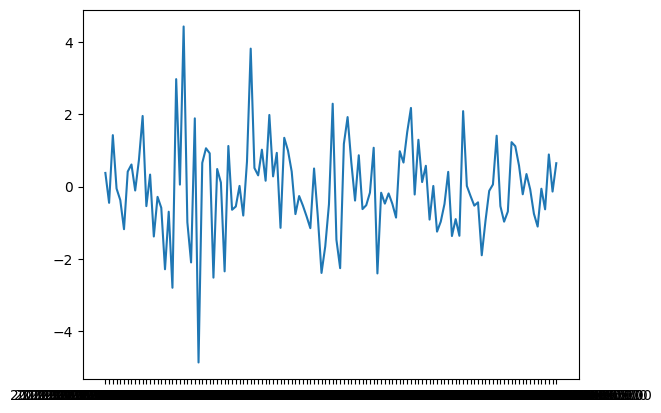

In [3]:
import matplotlib.pyplot as plt
plt.plot(values.loc['AIG']['Variation'][20:142])

In [4]:
adj = np.load('../data/SP100/raw/adj.npy')
adj[:5, :5]

array([[0.        , 0.        , 0.        , 0.25805462, 0.25805462],
       [0.        , 0.        , 0.51610923, 0.        , 0.        ],
       [0.        , 0.51610923, 0.        , 0.        , 0.        ],
       [0.25805462, 0.        , 0.        , 0.        , 0.51610923],
       [0.25805462, 0.        , 0.        , 0.51610923, 0.        ]])

### Creating the feature matrix and edge indices
The feature matrix is a 3d matrix of shape (timestamps_nb, stocks_nb, features_nb). The adjacency matrix is used to create the edge_index matrix in the PyTorch Geomtric format.

In [5]:
nodes_nb = len(adj)
x = np.array(
	values.drop(columns=["Close"]).to_numpy().reshape((nodes_nb, -1, values.shape[1] - 1))
)  # shape (nodes_nb, timestamps_nb, features_nb)
x = np.swapaxes(x, 0, 1)  # shape (timestamps_nb, nodes_nb, features_nb)

edge_nb = np.count_nonzero(adj)
edge_index = np.zeros((2, edge_nb))
edge_weight = np.zeros((edge_nb,))
count = 0
for i in range(nodes_nb):
	for j in range(nodes_nb):
		if (weight := adj[i, j]) != 0:
			edge_index[0, count], edge_index[1, count] = i, j
			edge_weight[count] = weight
			count += 1
x.shape, edge_index.shape, edge_weight.shape

((1234, 100, 6), (2, 2460), (2460,))

### Building the graphs
Finally, the graphs can be built using the Data class for PyG.

In [6]:
timestamps = [
	Data(x=x[idx, :, :], edge_index=edge_index, edge_weight=edge_weight) for idx in range(x.shape[0])
]
timestamps[:5]

[Data(x=[100, 6], edge_index=[2, 2460], edge_weight=[2460]),
 Data(x=[100, 6], edge_index=[2, 2460], edge_weight=[2460]),
 Data(x=[100, 6], edge_index=[2, 2460], edge_weight=[2460]),
 Data(x=[100, 6], edge_index=[2, 2460], edge_weight=[2460]),
 Data(x=[100, 6], edge_index=[2, 2460], edge_weight=[2460])]

In [12]:
forecasting_timestamps = [
	Data(x=x[idx:idx+20, :, :], edge_index=edge_index, edge_weight=edge_weight, y=x[idx+20, :, 0:1]) for idx in range(x.shape[0] - 20)
]
forecasting_timestamps[:5]

[Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460]),
 Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460]),
 Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460]),
 Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460]),
 Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460])]

## Defining the PyTorch Geometric datasets
The previously defined method is used to process the data and create a standard PyG Dataset class.
Two datasets are defined:
- The first dataset contains graphs with data for a single timestamps.
- The second dataset contains graphs with 3d node features -- data for the timestamps $[\![t, t+T[\![$ -- and a target variable -- the variation at time $t+T$ -- used for forecasting.

These datasets are used in the next notebooks to train and evaluate the forecasting model. The code is in the `datasets/SP100Stocks.py` and `datasets/SP100StocksForecasting.py` files.

In [7]:
from datasets.SP100Stocks import SP100Stocks
from datasets.SP100StocksForecasting import SP100StocksForecasting

In [8]:
dataset = SP100Stocks()
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(1234),
 Data(x=[100, 6], edge_index=[2, 2460], edge_weight=[2460], close_price=[100]))

In [9]:
forecasting_dataset = SP100StocksForecasting()
forecasting_dataset, forecasting_dataset[0]

Processing...
Done!


(SP100StocksForecasting(1214),
 Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460], close_price=[100, 20], close_price_y=[100, 1]))